In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_6958/2498054660.py:17: DtypeWarning: Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ga4_data.csv')


제가 집중한 가설: 이 서비스를 지속가능하게 만들기 위해선 매출이 적지만 꾸준하게 오는 고객을 집중해야 한다.

In [2]:
# 전처리 
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
df['fullVisitorId'] = df['fullVisitorId'].astype(str)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

df.visitStartTime = (df.visitStartTime - timedelta(hours=8))
# df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
# df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
# df = df.assign(day_name = df.visitStartTime.dt.weekday)

전체 세션중 정확하지 않은 세션 3.0 % 그리고 정확한 세션 97.0 % 


([<matplotlib.patches.Wedge at 0x2820fd4e0>,
 [Text(-1.095030317526183, 0.10444426120427588, '컬럼 일치'),
  Text(1.095030308358575, -0.1044443573206543, '컬럼 불일치')])

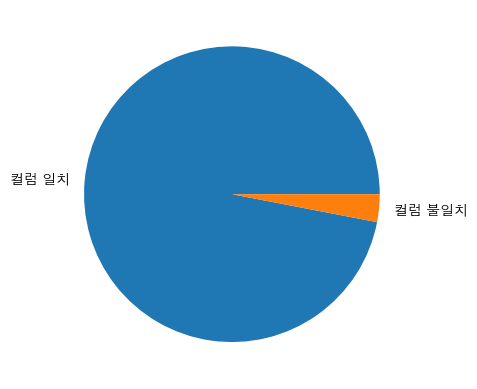

In [3]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

# 매출 데이터 컬럼 totals 와 hits 정합성 검사 
rev = df.groupby('visitId')[['totals_totalTransactionRevenue', 'hits_transaction_transactionRevenue']].sum().reset_index()
total_session_num = rev['visitId'].nunique()
# total and hits 가 똑같지 않은 세션의 수 
wrong_sessison_num = rev[rev['totals_totalTransactionRevenue'] != rev['hits_transaction_transactionRevenue']]['visitId'].nunique()
# total and hits 가 똑같은 세션의 수
right_session_num = rev[rev['totals_totalTransactionRevenue'] == rev['hits_transaction_transactionRevenue']]['visitId'].nunique()
print(f'전체 세션중 정확하지 않은 세션 {round(wrong_sessison_num / total_session_num * 100,1)} % 그리고 정확한 세션 {round(right_session_num / total_session_num * 100, 1)} % ')

label = ['컬럼 일치', '컬럼 불일치']
size = [right_session_num, wrong_sessison_num]
plt.pie(size, labels = label)

전체 고객 250143 명
구매 고객 9421 명
비구매 고객 247065 명
3.7662457074553353 비율


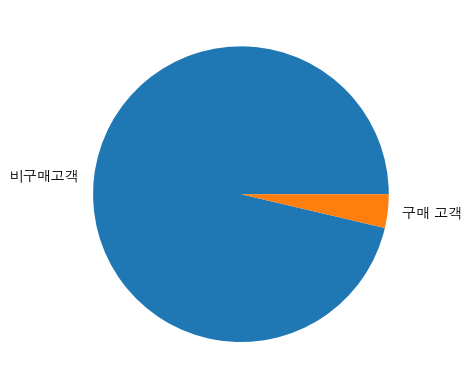

In [4]:
# 고객 현황 파악
# 전체 고객
print(f"전체 고객 {df['fullVisitorId'].nunique()} 명")
# 구매 고객
print(f"구매 고객 {df[df['totals_totalTransactionRevenue'] != 0]['fullVisitorId'].nunique()} 명")
# 비구매 고객
print(f"비구매 고객 {df[df['totals_totalTransactionRevenue'] == 0]['fullVisitorId'].nunique()} 명")

purchased = df[df['totals_totalTransactionRevenue'] != 0]['fullVisitorId'].nunique()
non_purchased = df[df['totals_totalTransactionRevenue'] == 0]['fullVisitorId'].nunique()
label = ['비구매고객', '구매 고객']
size = [non_purchased, purchased]
plt.pie(size, labels = label)

print(f'{(9421 / 250143) * 100} 비율')


8336 명이 한번만 구매, 1085 명이 두번 이상 구매, 10 명이 열두 번 이상 구매
10.986094894384884 비율


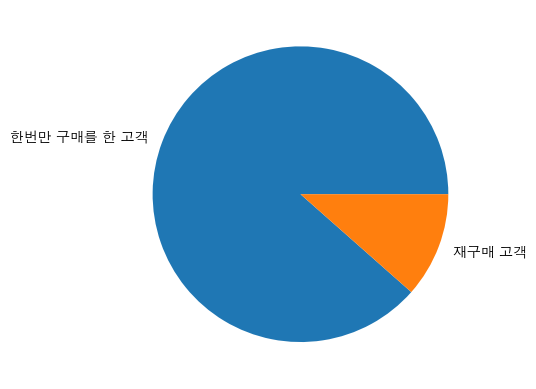

In [5]:
# 재구매를 "횟수로" -- totals
purchase_count = df[df['hits_transaction_transactionRevenue'] != 0]
purchase_count = purchase_count.groupby(['fullVisitorId']).count().reset_index()
more_than_once = purchase_count[purchase_count['hits_transaction_transactionRevenue'] >= 2]['fullVisitorId'].nunique()
once = purchase_count[purchase_count['hits_transaction_transactionRevenue'] <= 1]['fullVisitorId'].nunique()
more_than_twelve = purchase_count[purchase_count['hits_transaction_transactionRevenue'] >= 12]['fullVisitorId'].nunique()
print(f'{once} 명이 한번만 구매, {more_than_once} 명이 두번 이상 구매, {more_than_twelve} 명이 열두 번 이상 구매')

label = ['한번만 구매를 한 고객', '재구매 고객']
size = [once, more_than_once]
plt.pie(size, labels = label)

print(f'{(1035 / 9421) * 100} 비율')

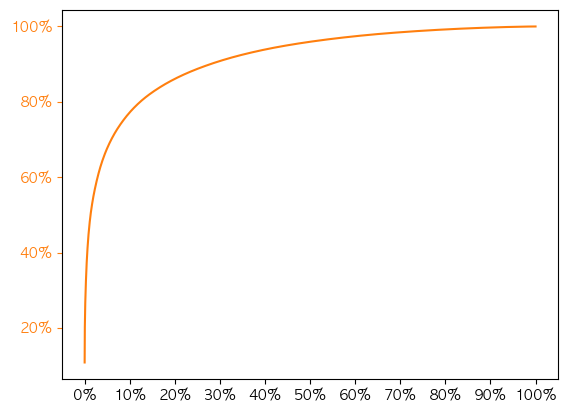

In [21]:
# 파레토
# id 기준으로 total revenue 의 합계를 구하고
# 전체 revenue 를 나눠서 매출 %를 보고 %의 파레토 차트를 그린다

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

non_zero = df[df['totals_totalTransactionRevenue'] != 0]
indv = non_zero.groupby('fullVisitorId')['totals_totalTransactionRevenue'].sum().reset_index()
indv = indv.sort_values('totals_totalTransactionRevenue', ascending=False)
indv['revenue_pct'] = indv['totals_totalTransactionRevenue'].cumsum() / indv['totals_totalTransactionRevenue'].sum() * 100
indv['id_count'] = indv.groupby('fullVisitorId').cumcount() + 1
indv['id_pct'] = indv['id_count'].cumsum() / indv['id_count'].sum() * 100

# indv.to_csv('pareto.csv', index=False)

fig, ax = plt.subplots()
ax.plot(indv['id_pct'], indv["revenue_pct"], color="C1", ms=7)

ax.xaxis.set_major_formatter(PercentFormatter())
ax.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="C1")
plt.xticks(np.arange(0, 101, 10.0))
plt.show()

vvip 기준 - 매출 상위 20 퍼

In [91]:
#매출 90퍼를 차지하는 20퍼센트의 고객이 vvip 로 나와야한다. revenue_pct 가 90퍼 이하인 id 만 뽑아서 vvip로 취급한다. vvip는 총 2625명
vvip_ids = indv[indv['revenue_pct'] <= 90]['fullVisitorId'].unique()

#vvip 고객을 추출한다
vvip_df = df[['fullVisitorId', 'totals_totalTransactionRevenue', 'visitStartTime']]
vvip_df = vvip_df[vvip_df['fullVisitorId'].isin(vvip_ids)]

# 매출이 0 이 아닌 데이터만 필터링 한다
vvip_df = vvip_df[vvip_df['totals_totalTransactionRevenue'] != 0]

#vvip의 리텐션 == 일별 구매 횟수 (고객별 totalTransactionRevenue 가 0 이 아닌 날짜의 고유값) 를 본다. 하루에 10번을 구매해도 한번 구매로 친다. == 우리의 리텐션 기준 --> 중요 중요!!
vvip_df['fulldate'] = vvip_df['visitStartTime'].dt.date
vvip_retention = vvip_df.groupby('fullVisitorId')['fulldate'].nunique().reset_index()
vvip_retention.rename(columns={'fulldate': 'retention'}, inplace=True)
vvip_retention = vvip_retention.sort_values('retention', ascending=False)

print(f"vvip 평균 리텐션 {vvip_retention['retention'].mean()} 번")

#vvip 평균 리텐션의 분포 확인
vvip_retention['retention'] = round(vvip_retention['retention'], 0)
temp_count = vvip_retention.groupby('retention')['fullVisitorId'].nunique().reset_index()
temp_count.rename(columns={'fullVisitorId': 'counts'}, inplace=True)

import plotly.express as px
fig = px.bar(temp_count, x="retention", y="counts")
fig.show()

# # 6번 이상 구매한 사람은 아웃라이어로 취급
# vvip_ids = vvip_retention[vvip_retention['retention'] <= 5]['fullVisitorId'].unique()

# #전체 매출
# total_rev = df['totals_totalTransactionRevenue'].sum()
# #vvip 가 한번에 쓰는 돈 계산
# vvip_df = df[['fullVisitorId', 'totals_totalTransactionRevenue', 'visitStartTime']]
# vvip_df = vvip_df[vvip_df['fullVisitorId'].isin(vvip_ids)]
# vvip_df = vvip_df[vvip_df['totals_totalTransactionRevenue'] != 0]
# revenue_df = vvip_df['totals_totalTransactionRevenue'].sum()
# #전체 매출 대비 vvip 매출 (한번에 쓸때)
# print(f"전체 매출 대비 vvip 한번 매출 {round(revenue_df / total_rev * 100, 1)} %")

vvip 평균 리텐션 1.392 번


target 기준 -- 매출 하위 80퍼센트
그중에서도 찾을 수 있다면 리텐션이 아주 높은 사람들 (구매를 꾸준히 한 사람들)

In [120]:
#매출 10퍼를 차지하는 80퍼센트의 고객을 타겟 고객으로 잡는다. revenue_pct 가 90퍼 이상인 id 만 뽑아서 target로 취급한다. 
#다시 쓰기 귀찮아서 vvip 로직을 함수로 만들어 퍼센트지 등호만 바꿔 주었다.
def get_target_retention(pct_num):
    vvip_ids = indv[indv['revenue_pct'] > pct_num]['fullVisitorId'].unique()

    #vvip 고객을 추출한다
    vvip_df = df[['fullVisitorId', 'totals_totalTransactionRevenue', 'visitStartTime']]
    vvip_df = vvip_df[vvip_df['fullVisitorId'].isin(vvip_ids)]

    # 매출이 0 이 아닌 데이터만 필터링 한다
    vvip_df = vvip_df[vvip_df['totals_totalTransactionRevenue'] != 0]

    #vvip의 리텐션 == 일별 구매 횟수 (고객별 totalTransactionRevenue 가 0 이 아닌 날짜의 고유값) 를 본다. 하루에 10번을 구매해도 한번 구매로 친다. == 우리의 리텐션 기준 --> 중요 중요!!
    vvip_df['fulldate'] = vvip_df['visitStartTime'].dt.date
    vvip_retention = vvip_df.groupby('fullVisitorId')['fulldate'].nunique().reset_index()
    vvip_retention.rename(columns={'fulldate': 'retention'}, inplace=True)
    vvip_retention = vvip_retention.sort_values('retention', ascending=False)

    print(f"타겟 고객 평균 리텐션 {vvip_retention['retention'].mean()} 번")

    #vvip 평균 리텐션의 분포 확인
    vvip_retention['retention'] = round(vvip_retention['retention'], 0)
    temp_count = vvip_retention.groupby('retention')['fullVisitorId'].nunique().reset_index()
    temp_count.rename(columns={'fullVisitorId': 'counts'}, inplace=True)

    import plotly.express as px
    fig = px.bar(temp_count, x="retention", y="counts")
    fig.show()

    # 6번 이상 구매한 사람은 아웃라이어로 취급
    vvip_ids = vvip_retention[vvip_retention['retention'] <= 5]['fullVisitorId'].unique()

    #전체 매출
    total_rev = df['totals_totalTransactionRevenue'].sum()
    #vvip 가 한번에 쓰는 돈 계산
    vvip_df = df[['fullVisitorId', 'totals_totalTransactionRevenue', 'visitStartTime']]
    vvip_df = vvip_df[vvip_df['fullVisitorId'].isin(vvip_ids)]
    vvip_df = vvip_df[vvip_df['totals_totalTransactionRevenue'] != 0]
    revenue_df = vvip_df['totals_totalTransactionRevenue'].sum()
    #전체 매출 대비 vvip 매출 (한번에 쓸때)
    print(f"전체 매출 대비 타겟 한번 매출 {round(revenue_df / total_rev * 100, 1)} %")
    
get_target_retention(90)

타겟 고객 평균 리텐션 1.046203649205415 번


전체 매출 대비 타겟 한번 매출 10.0 %


제가 내린 결론은...우리가 찾고 싶었던 고객은 찾기가 어렵다는 것...
우리가 찾고 싶었던 고객은 매출이 낮아도 "꾸준히 오는 고객" 인데,

매출이 높은 상위 10% 고객들중에 오히려 재방문이 25번이 되는 고객이 있고, 매출이 낮은 사람들중에서는 최대 재방문이 5번이라고 결과가 나왔어요.

오히려 매출이 높은 상위 10%한테 집중해야하는 서비스가 아닌가 싶습니다

가설: vvip 들은 한번에 대량 구매하는 사람들이다. 구매하는 시간대가 오전 9시에서 오후 6시 사이일 것이다.

In [6]:
df['visitStartTime'].dt.hour.sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

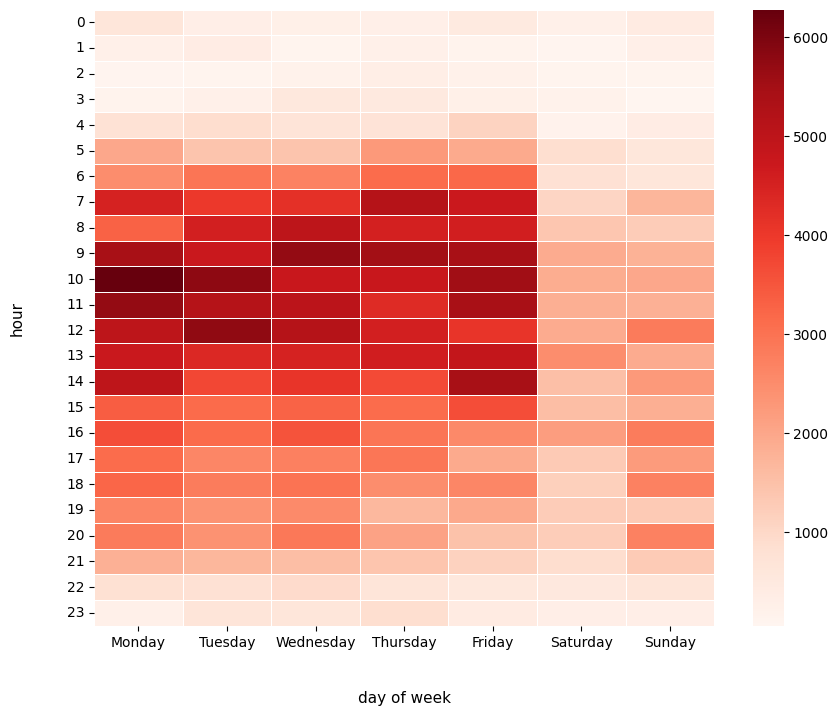

In [4]:
#전체 구매 고객의 구매시간대와 요일과 vvip 의 구매 시간대, 요일을 비교한다
hourday = df[['fullVisitorId', 'visitId', 'visitStartTime', 'totals_totalTransactionRevenue']]
hourday = hourday[hourday['totals_totalTransactionRevenue'] != 0]

# day, time 컬럼 계산
hourday['day'] = hourday['visitStartTime'].dt.day_name()
hourday['time'] = hourday['visitStartTime'].dt.hour

# total tran 이 찍힌 세션의 개수 계산
hourday = hourday.groupby(['day', 'time'])['visitId'].count().reset_index()
hourday.head()

# pivot
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_count = hourday.pivot(index='time', columns='day', values='visitId')
week_count = week_count.reindex(columns=order)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(data=week_count, linewidth=0.5, cmap='Reds')

plt.xlabel('day of week', fontsize=11,labelpad=30)
plt.ylabel('hour', fontsize=11,rotation=90,labelpad=30)
#y축 레이블 축 변경 하기
plt.yticks(rotation=360)
#테이블 보여주기
plt.show()

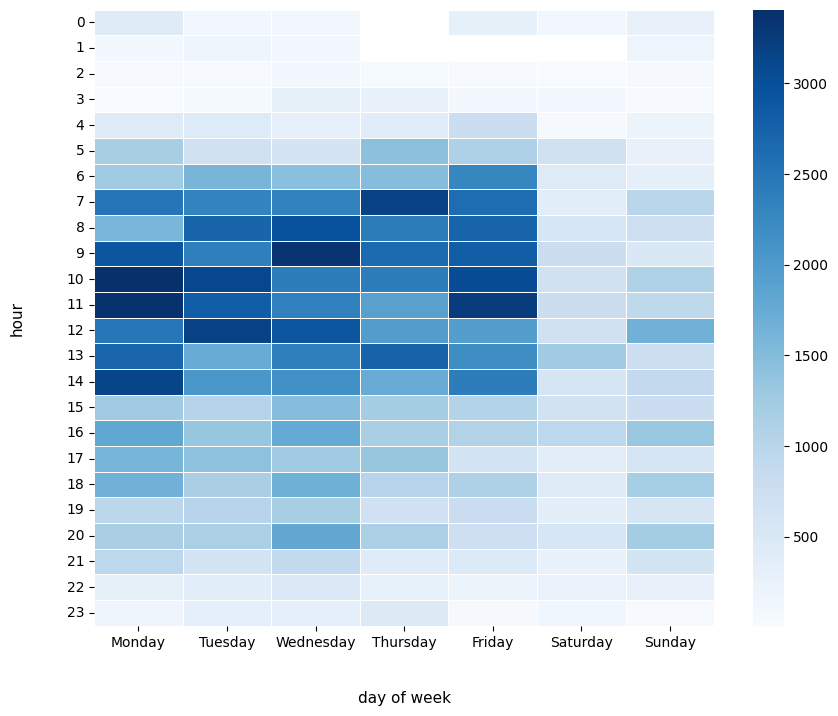

In [7]:
#vvip 들의 구매하는 시간대와 요일을 히트맵으로 그린다.
vvip_ids = indv[indv['revenue_pct'] <= 90]['fullVisitorId'].unique()

#df의 id, sessionid, date, visitStartTime, total_trans 컬럼을 사용.
#hits_revenue 보다 total_revenue 컬럼을 사용하는 이유는, 편의성을 위해. 한 세션에 구매를 했으면 total_revenue 는 모든 세션 데이터에 찍힌다.
#따라서 그 시간대 접속한 고객이 세션에 total_revenue 가 찍히면 구매를 했다는 것이다. 
#따라서 [day, hour] 로 묶어서 total_revenue 가 찍힌 세션의 개수를 "시간대별 구매 횟수" 로 계산한다.
hourday = df[['fullVisitorId', 'visitId', 'visitStartTime', 'totals_totalTransactionRevenue']]
hourday = hourday[hourday['fullVisitorId'].isin(vvip_ids)]
hourday = hourday[hourday['totals_totalTransactionRevenue'] != 0]

# day, time 컬럼 계산
hourday['day'] = hourday['visitStartTime'].dt.day_name()
hourday['time'] = hourday['visitStartTime'].dt.hour

# total tran 이 찍힌 세션의 개수 계산
hourday = hourday.groupby(['day', 'time'])['visitId'].count().reset_index()
hourday.head()

# pivot
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_count = hourday.pivot(index='time', columns='day', values='visitId')
week_count = week_count.reindex(columns=order)
    
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(data=week_count, linewidth=0.5, cmap='Blues')

plt.xlabel('day of week', fontsize=11,labelpad=30)
plt.ylabel('hour', fontsize=11,rotation=90,labelpad=30)
#y축 레이블 축 변경 하기
plt.yticks(rotation=360)
#테이블 보여주기
plt.show()



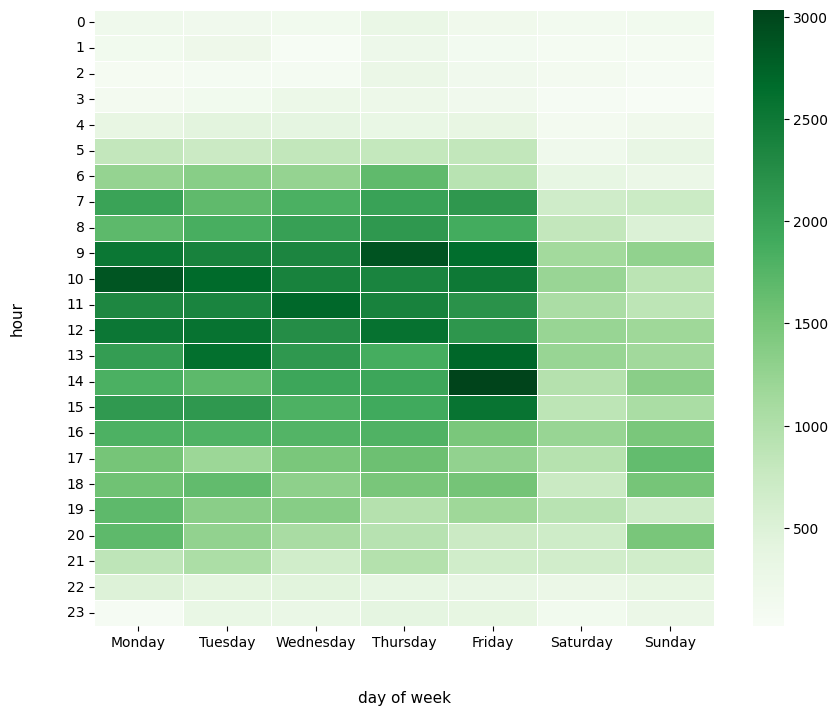

In [8]:
#plain 들의 구매하는 시간대와 요일을 히트맵으로 그린다.
plain_ids = indv[indv['revenue_pct'] > 90]['fullVisitorId'].unique()

#df의 id, sessionid, date, visitStartTime, total_trans 컬럼을 사용.
#hits_revenue 보다 total_revenue 컬럼을 사용하는 이유는, 편의성을 위해. 한 세션에 구매를 했으면 total_revenue 는 모든 세션 데이터에 찍힌다.
#따라서 그 시간대 접속한 고객이 세션에 total_revenue 가 찍히면 구매를 했다는 것이다. 
#따라서 [day, hour] 로 묶어서 total_revenue 가 찍힌 세션의 개수를 "시간대별 구매 횟수" 로 계산한다.
hourday = df[['fullVisitorId', 'visitId', 'visitStartTime', 'totals_totalTransactionRevenue']]
hourday = hourday[hourday['fullVisitorId'].isin(plain_ids)]
hourday = hourday[hourday['totals_totalTransactionRevenue'] != 0]

# day, time 컬럼 계산
hourday['day'] = hourday['visitStartTime'].dt.day_name()
hourday['time'] = hourday['visitStartTime'].dt.hour

# total tran 이 찍힌 세션의 개수 계산
hourday = hourday.groupby(['day', 'time'])['visitId'].count().reset_index()
hourday.head()

# pivot
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_count = hourday.pivot(index='time', columns='day', values='visitId')
week_count = week_count.reindex(columns=order)
    
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(data=week_count, linewidth=0.5, cmap='Greens')

plt.xlabel('day of week', fontsize=11,labelpad=30)
plt.ylabel('hour', fontsize=11,rotation=90,labelpad=30)
#y축 레이블 축 변경 하기
plt.yticks(rotation=360)
#테이블 보여주기
plt.show()



전체 구매고객의 패턴은 주중에 구매하고, 오전 6시에서 3시 사이에 가장 많이 구매한다.

In [ ]:
# 왜 체류시간이 30분이 넘어가지.....???? 250 분이 걸린 사람의 로그를 한번 보자.

In [ ]:
#리텐션

# df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
# total_rev = df.groupby(['fullVisitorId']).sum('hits_transaction_transactionRevenue')
# total_rev = total_rev.reset_index()
# vvips = total_rev[total_rev['hits_transaction_transactionRevenue'] >= 40000]['fullVisitorId']
# print(vvips.values)
# for id in vvips.values:
#     temp = df[df['fullVisitorId'] == id]
#     temp['date'] = temp['visitStartTime'].dt.strftime('%Y-%m-%d')
    
#     # Group by date and count visitId
#     visit_counts = temp.groupby('date')['visitId'].count()
    
#     # Plotting
#     plt.figure(figsize=(10, 6))  # Adjust figure size as needed
#     plt.plot(visit_counts.index, visit_counts.values, marker='o', color='blue', linestyle='-')
#     plt.xlabel('Date')
#     plt.ylabel('Visit count')
#     plt.title(f'Visit count for fullVisitorId: {id}')
#     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
    